In [26]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import random
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import pandas as pd
from scipy.ndimage import gaussian_filter1d

from epistatic_net.wht_sampling import SPRIGHTSample
from epistatic_net.spright_utils import SPRIGHT, make_system_simple

from utils import ModelTrainer
from datasets import FourierDataset

# Set seeds
random_seed = 55
fix_seed = 1
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

In [2]:
class FCN(nn.Module):
    def __init__(self, n, multiplier=2, batch_norm=False):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(n, multiplier*n)
        self.fc2 = nn.Linear(multiplier*n, multiplier*n)
        self.fc3 = nn.Linear(multiplier*n, n)
        self.fc4 = nn.Linear(n, 1)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn1 = nn.BatchNorm1d(multiplier*n)
            self.bn2 = nn.BatchNorm1d(multiplier*n)
            self.bn3 = nn.BatchNorm1d(n)

    def forward(self, x):
        if self.batch_norm:
            x = self.bn1(F.leaky_relu(self.fc1(x)))
            x = self.bn2(F.leaky_relu(self.fc2(x)))
            x = self.bn3(F.leaky_relu(self.fc3(x)))
            x = self.fc4(x)
        else:
            x = F.leaky_relu(self.fc1(x))
            x = F.leaky_relu(self.fc2(x))
            x = F.leaky_relu(self.fc3(x))
            x = self.fc4(x)

        return x.reshape(-1)

In [59]:
test_n = 10
test_k = 10
test_d = 5
test_b = 4
dataset_size_coef = 8
test_n_samples =  2**test_n

dataset = FourierDataset(n=test_n, k=test_k, d=test_d, n_samples=test_n_samples, random_seed=fix_seed,
                        freq_sampling_method="single_deg", amp_sampling_method="constant")
print(sorted(dataset.get_int_freqs()))
print(sorted(dataset.amp_f))
print(dataset.X.shape)

[25, 48, 253, 512, 533, 789, 917, 1019, 1020, 1023]
[tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.)]
torch.Size([1024, 10])


In [60]:
train_ds = torch.utils.data.Subset(dataset, list(range(dataset_size_coef * test_k * test_n)))
val_ds = torch.utils.data.Subset(dataset, list(range(dataset_size_coef * test_k * test_n, test_n_samples)))
print(len(train_ds), len(val_ds))

800 224


#0 - Train Loss: 0.110, R2: -0.046	Validation Loss: 0.087, R2: -0.238
#1 - Train Loss: 0.101, R2: 0.032	Validation Loss: 0.071, R2: -0.017
#2 - Train Loss: 0.102, R2: 0.029	Validation Loss: 0.073, R2: -0.049
#3 - Train Loss: 0.098, R2: 0.065	Validation Loss: 0.069, R2: 0.016
#4 - Train Loss: 0.096, R2: 0.079	Validation Loss: 0.071, R2: -0.014
#5 - Train Loss: 0.094, R2: 0.100	Validation Loss: 0.068, R2: 0.022
#6 - Train Loss: 0.090, R2: 0.144	Validation Loss: 0.070, R2: -0.002
#7 - Train Loss: 0.085, R2: 0.191	Validation Loss: 0.071, R2: -0.011
#8 - Train Loss: 0.081, R2: 0.228	Validation Loss: 0.077, R2: -0.102
#9 - Train Loss: 0.079, R2: 0.244	Validation Loss: 0.074, R2: -0.057
#10 - Train Loss: 0.072, R2: 0.315	Validation Loss: 0.073, R2: -0.038
#11 - Train Loss: 0.068, R2: 0.352	Validation Loss: 0.070, R2: 0.001
#12 - Train Loss: 0.066, R2: 0.373	Validation Loss: 0.060, R2: 0.140
#13 - Train Loss: 0.062, R2: 0.411	Validation Loss: 0.079, R2: -0.128
#14 - Train Loss: 0.059, R2: 0.43

#119 - Train Loss: 0.005, R2: 0.953	Validation Loss: 0.089, R2: -0.270
#120 - Train Loss: 0.004, R2: 0.959	Validation Loss: 0.082, R2: -0.176
#121 - Train Loss: 0.005, R2: 0.954	Validation Loss: 0.086, R2: -0.227
#122 - Train Loss: 0.004, R2: 0.963	Validation Loss: 0.098, R2: -0.395
#123 - Train Loss: 0.006, R2: 0.940	Validation Loss: 0.087, R2: -0.250
#124 - Train Loss: 0.009, R2: 0.917	Validation Loss: 0.086, R2: -0.223
#125 - Train Loss: 0.008, R2: 0.923	Validation Loss: 0.084, R2: -0.194
#126 - Train Loss: 0.008, R2: 0.927	Validation Loss: 0.094, R2: -0.337
#127 - Train Loss: 0.008, R2: 0.921	Validation Loss: 0.088, R2: -0.264
#128 - Train Loss: 0.005, R2: 0.951	Validation Loss: 0.088, R2: -0.263
#129 - Train Loss: 0.004, R2: 0.960	Validation Loss: 0.087, R2: -0.246
#130 - Train Loss: 0.004, R2: 0.962	Validation Loss: 0.089, R2: -0.268
#131 - Train Loss: 0.003, R2: 0.970	Validation Loss: 0.092, R2: -0.321
#132 - Train Loss: 0.003, R2: 0.970	Validation Loss: 0.083, R2: -0.193
#133 -

#36 - Train Loss: 0.036, R2: 0.661	Validation Loss: 0.063, R2: 0.093
#37 - Train Loss: 0.034, R2: 0.672	Validation Loss: 0.061, R2: 0.129
#38 - Train Loss: 0.030, R2: 0.717	Validation Loss: 0.066, R2: 0.053
#39 - Train Loss: 0.035, R2: 0.670	Validation Loss: 0.061, R2: 0.126
#40 - Train Loss: 0.029, R2: 0.726	Validation Loss: 0.064, R2: 0.092
#41 - Train Loss: 0.030, R2: 0.713	Validation Loss: 0.065, R2: 0.077
#42 - Train Loss: 0.028, R2: 0.730	Validation Loss: 0.068, R2: 0.024
#43 - Train Loss: 0.025, R2: 0.762	Validation Loss: 0.072, R2: -0.023
#44 - Train Loss: 0.024, R2: 0.772	Validation Loss: 0.069, R2: 0.016
#45 - Train Loss: 0.024, R2: 0.769	Validation Loss: 0.066, R2: 0.056
#46 - Train Loss: 0.023, R2: 0.779	Validation Loss: 0.066, R2: 0.060
#47 - Train Loss: 0.022, R2: 0.794	Validation Loss: 0.067, R2: 0.048
#48 - Train Loss: 0.022, R2: 0.795	Validation Loss: 0.070, R2: 0.000
#49 - Train Loss: 0.021, R2: 0.802	Validation Loss: 0.070, R2: -0.007
#50 - Train Loss: 0.019, R2: 0.8

#154 - Train Loss: 0.005, R2: 0.954	Validation Loss: 0.066, R2: 0.060
#155 - Train Loss: 0.004, R2: 0.959	Validation Loss: 0.063, R2: 0.099
#156 - Train Loss: 0.005, R2: 0.957	Validation Loss: 0.062, R2: 0.113
#157 - Train Loss: 0.006, R2: 0.945	Validation Loss: 0.067, R2: 0.048
#158 - Train Loss: 0.005, R2: 0.954	Validation Loss: 0.066, R2: 0.059
#159 - Train Loss: 0.003, R2: 0.967	Validation Loss: 0.061, R2: 0.125
#160 - Train Loss: 0.003, R2: 0.972	Validation Loss: 0.065, R2: 0.077
#161 - Train Loss: 0.003, R2: 0.968	Validation Loss: 0.061, R2: 0.122
#162 - Train Loss: 0.003, R2: 0.968	Validation Loss: 0.060, R2: 0.139
#163 - Train Loss: 0.003, R2: 0.969	Validation Loss: 0.060, R2: 0.147
#164 - Train Loss: 0.003, R2: 0.968	Validation Loss: 0.060, R2: 0.137
#165 - Train Loss: 0.004, R2: 0.963	Validation Loss: 0.060, R2: 0.137
#166 - Train Loss: 0.004, R2: 0.961	Validation Loss: 0.062, R2: 0.108
#167 - Train Loss: 0.004, R2: 0.962	Validation Loss: 0.060, R2: 0.147
#168 - Train Loss: 0

#72 - Train Loss: 0.023, R2: 0.780	Validation Loss: 0.055, R2: 0.210
#73 - Train Loss: 0.022, R2: 0.790	Validation Loss: 0.056, R2: 0.193
#74 - Train Loss: 0.021, R2: 0.796	Validation Loss: 0.073, R2: -0.042
#75 - Train Loss: 0.023, R2: 0.783	Validation Loss: 0.056, R2: 0.206
#76 - Train Loss: 0.020, R2: 0.807	Validation Loss: 0.060, R2: 0.149
#77 - Train Loss: 0.020, R2: 0.807	Validation Loss: 0.087, R2: -0.238
#78 - Train Loss: 0.019, R2: 0.815	Validation Loss: 0.058, R2: 0.173
#79 - Train Loss: 0.019, R2: 0.820	Validation Loss: 0.362, R2: -4.170
#80 - Train Loss: 0.024, R2: 0.768	Validation Loss: 0.065, R2: 0.075
#81 - Train Loss: 0.023, R2: 0.784	Validation Loss: 0.055, R2: 0.209
#82 - Train Loss: 0.019, R2: 0.814	Validation Loss: 0.056, R2: 0.203
#83 - Train Loss: 0.019, R2: 0.819	Validation Loss: 0.056, R2: 0.196
#84 - Train Loss: 0.016, R2: 0.852	Validation Loss: 0.056, R2: 0.207
#85 - Train Loss: 0.016, R2: 0.844	Validation Loss: 0.055, R2: 0.211
#86 - Train Loss: 0.016, R2: 0.

#189 - Train Loss: 0.019, R2: 0.822	Validation Loss: 0.979, R2: -12.989
#190 - Train Loss: 0.009, R2: 0.916	Validation Loss: 0.046, R2: 0.347
#191 - Train Loss: 0.006, R2: 0.940	Validation Loss: 0.043, R2: 0.381
#192 - Train Loss: 0.004, R2: 0.958	Validation Loss: 0.040, R2: 0.430
#193 - Train Loss: 0.004, R2: 0.965	Validation Loss: 0.036, R2: 0.488
#194 - Train Loss: 0.013, R2: 0.871	Validation Loss: 0.161, R2: -1.301
#195 - Train Loss: 0.020, R2: 0.809	Validation Loss: 0.047, R2: 0.334
#196 - Train Loss: 0.012, R2: 0.890	Validation Loss: 0.048, R2: 0.311
#197 - Train Loss: 0.007, R2: 0.936	Validation Loss: 0.050, R2: 0.282
#198 - Train Loss: 0.004, R2: 0.962	Validation Loss: 0.051, R2: 0.267
#199 - Train Loss: 0.003, R2: 0.971	Validation Loss: 0.368, R2: -4.264
#0 - Train Loss: 0.106, R2: -0.013	Validation Loss: 0.070, R2: -0.003
#1 - Train Loss: 0.096, R2: 0.080	Validation Loss: 0.071, R2: -0.017
#2 - Train Loss: 0.099, R2: 0.058	Validation Loss: 0.068, R2: 0.026
#3 - Train Loss: 0.

#109 - Train Loss: 0.002, R2: 0.979	Validation Loss: 0.031, R2: 0.561
#110 - Train Loss: 0.002, R2: 0.981	Validation Loss: 0.030, R2: 0.570
#111 - Train Loss: 0.002, R2: 0.983	Validation Loss: 0.030, R2: 0.575
#112 - Train Loss: 0.002, R2: 0.982	Validation Loss: 0.028, R2: 0.598
#113 - Train Loss: 0.001, R2: 0.987	Validation Loss: 0.028, R2: 0.602
#114 - Train Loss: 0.001, R2: 0.988	Validation Loss: 0.028, R2: 0.603
#115 - Train Loss: 0.001, R2: 0.988	Validation Loss: 0.027, R2: 0.616
#116 - Train Loss: 0.001, R2: 0.987	Validation Loss: 0.027, R2: 0.614
#117 - Train Loss: 0.001, R2: 0.986	Validation Loss: 0.026, R2: 0.630
#118 - Train Loss: 0.001, R2: 0.987	Validation Loss: 0.026, R2: 0.630
#119 - Train Loss: 0.002, R2: 0.981	Validation Loss: 0.027, R2: 0.618
#120 - Train Loss: 0.002, R2: 0.979	Validation Loss: 0.026, R2: 0.628
#121 - Train Loss: 0.002, R2: 0.978	Validation Loss: 0.028, R2: 0.603
#122 - Train Loss: 0.002, R2: 0.984	Validation Loss: 0.025, R2: 0.647
#123 - Train Loss: 0

#28 - Train Loss: 0.046, R2: 0.558	Validation Loss: 0.067, R2: 0.039
#29 - Train Loss: 0.044, R2: 0.583	Validation Loss: 0.072, R2: -0.032
#30 - Train Loss: 0.043, R2: 0.586	Validation Loss: 0.079, R2: -0.125
#31 - Train Loss: 0.044, R2: 0.585	Validation Loss: 0.070, R2: -0.007
#32 - Train Loss: 0.041, R2: 0.608	Validation Loss: 0.070, R2: 0.006
#33 - Train Loss: 0.040, R2: 0.617	Validation Loss: 0.074, R2: -0.051
#34 - Train Loss: 0.041, R2: 0.611	Validation Loss: 0.076, R2: -0.079
#35 - Train Loss: 0.040, R2: 0.620	Validation Loss: 0.070, R2: 0.003
#36 - Train Loss: 0.040, R2: 0.614	Validation Loss: 0.081, R2: -0.160
#37 - Train Loss: 0.039, R2: 0.624	Validation Loss: 0.078, R2: -0.109
#38 - Train Loss: 0.039, R2: 0.629	Validation Loss: 0.074, R2: -0.054
#39 - Train Loss: 0.038, R2: 0.636	Validation Loss: 0.072, R2: -0.028
#40 - Train Loss: 0.038, R2: 0.636	Validation Loss: 0.076, R2: -0.091
#41 - Train Loss: 0.036, R2: 0.659	Validation Loss: 0.079, R2: -0.130
#42 - Train Loss: 0.037

#146 - Train Loss: 0.019, R2: 0.820	Validation Loss: 0.097, R2: -0.385
#147 - Train Loss: 0.017, R2: 0.841	Validation Loss: 0.097, R2: -0.383
#148 - Train Loss: 0.016, R2: 0.851	Validation Loss: 0.098, R2: -0.401
#149 - Train Loss: 0.018, R2: 0.825	Validation Loss: 0.104, R2: -0.486
#150 - Train Loss: 0.017, R2: 0.838	Validation Loss: 0.098, R2: -0.393
#151 - Train Loss: 0.017, R2: 0.839	Validation Loss: 0.099, R2: -0.418
#152 - Train Loss: 0.017, R2: 0.840	Validation Loss: 0.103, R2: -0.474
#153 - Train Loss: 0.016, R2: 0.849	Validation Loss: 0.103, R2: -0.474
#154 - Train Loss: 0.015, R2: 0.853	Validation Loss: 0.105, R2: -0.507
#155 - Train Loss: 0.017, R2: 0.842	Validation Loss: 0.106, R2: -0.517
#156 - Train Loss: 0.016, R2: 0.850	Validation Loss: 0.105, R2: -0.500
#157 - Train Loss: 0.015, R2: 0.857	Validation Loss: 0.101, R2: -0.439
#158 - Train Loss: 0.015, R2: 0.854	Validation Loss: 0.106, R2: -0.521
#159 - Train Loss: 0.017, R2: 0.837	Validation Loss: 0.102, R2: -0.458
#160 -

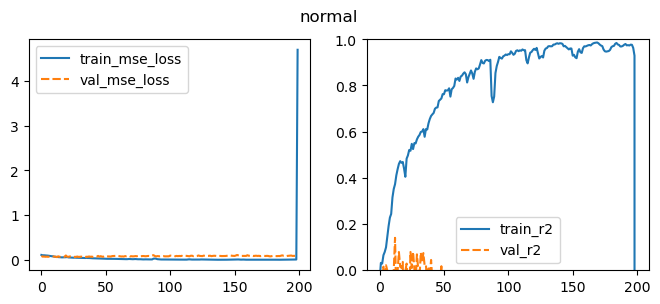

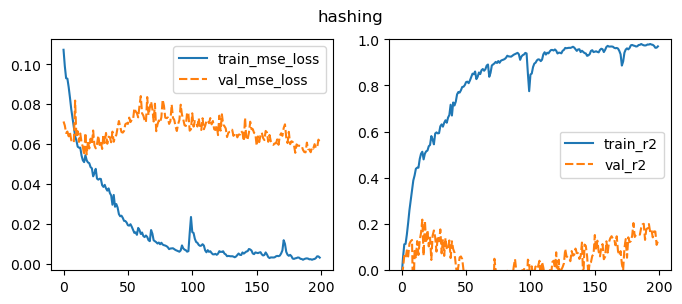

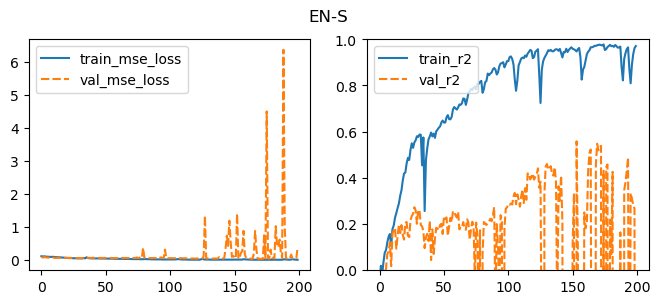

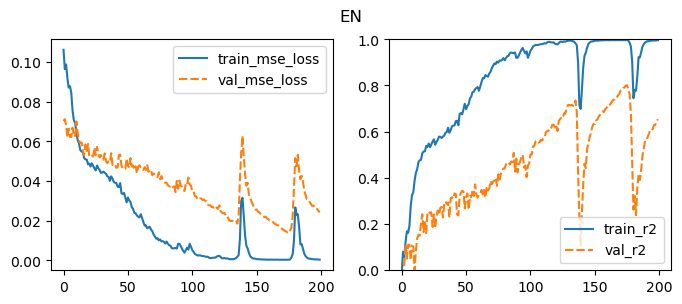

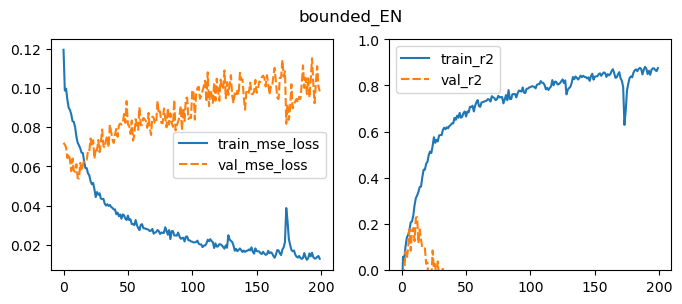

In [61]:
config = {
    "training_method": "normal",
    "add_hadamard_loss": True, 
    "n": test_n,
    "k": test_k,
    "b": test_b+2,
    "d": test_d,
    "SPRIGHT_d": 5,
    "rho": 0.01,
    "lr": 0.01, 
    "weight_decay": 0, 
    "hadamard_lambda": 0.001,
    "num_epochs": 200,
    "batch_size": 16,
    "random_seed": random_seed,
    "fix_seed": fix_seed,
    "fix_deg": True,
    "train_size": len(train_ds),
    "network_c": 10,
    "run": 2,
}

results = {}

# Train model
in_dim = dataset.X.shape[1]
args = {"int_freqs": dataset.get_int_freqs(), "amps": dataset.amp_f.cpu().numpy()}

torch.manual_seed(random_seed)
model = FCN(in_dim, config["network_c"])
trainer = ModelTrainer(model, train_ds, val_ds, config=config, report_epoch_fourier=True, plot_results=True, checkpoint_cache=True, **args)
spectrums = trainer.train_model()
best = np.argmin([l["val_mse_loss"] for l in trainer.logs[1:]])+1
results[config["training_method"]] = {"spectrums": spectrums, "best": best}

torch.manual_seed(random_seed)
model = FCN(in_dim, config["network_c"])
config["training_method"] = "hashing"
config["hadamard_lambda"] = 0.001
trainer = ModelTrainer(model, train_ds, val_ds, config=config, report_epoch_fourier=True, plot_results=True, checkpoint_cache=True, **args)
spectrums = trainer.train_model()
best = np.argmin([l["val_mse_loss"] for l in trainer.logs[1:]])+1
results[config["training_method"]] = {"spectrums": spectrums, "best": best}

torch.manual_seed(random_seed)
model = FCN(in_dim, config["network_c"])
config["training_method"] = "EN-S"
config["hadamard_lambda"] = 1
config["b"] = test_b
trainer = ModelTrainer(model, train_ds, val_ds, config=config, report_epoch_fourier=True, plot_results=True, checkpoint_cache=True, **args)
spectrums = trainer.train_model()
best = np.argmin([l["val_mse_loss"] for l in trainer.logs[1:]])+1
results[config["training_method"]] = {"spectrums": spectrums, "best": best}

torch.manual_seed(random_seed)
model = FCN(in_dim, config["network_c"])
config["training_method"] = "EN"
config["hadamard_lambda"] = 0.1
trainer = ModelTrainer(model, train_ds, val_ds, config=config, report_epoch_fourier=True, plot_results=True, checkpoint_cache=True, **args)
spectrums = trainer.train_model()
best = np.argmin([l["val_mse_loss"] for l in trainer.logs[1:]])+1
results[config["training_method"]] = {"spectrums": spectrums, "best": best}

torch.manual_seed(random_seed)
model = FCN(in_dim, 2)
config["training_method"] = "bounded_EN"
config["hadamard_lambda"] = 0.0001
config["deg_bound"] = 2
trainer = ModelTrainer(model, train_ds, val_ds, config=config, report_epoch_fourier=True, plot_results=True, checkpoint_cache=True, **args)
spectrums = trainer.train_model()
best = np.argmin([l["val_mse_loss"] for l in trainer.logs[1:]])+1
results[config["training_method"]] = {"spectrums": spectrums, "best": best}

# Fourier evolution

## Models comparison

/scratch/251685174.tmpdir/ipykernel_129130/4023826564.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


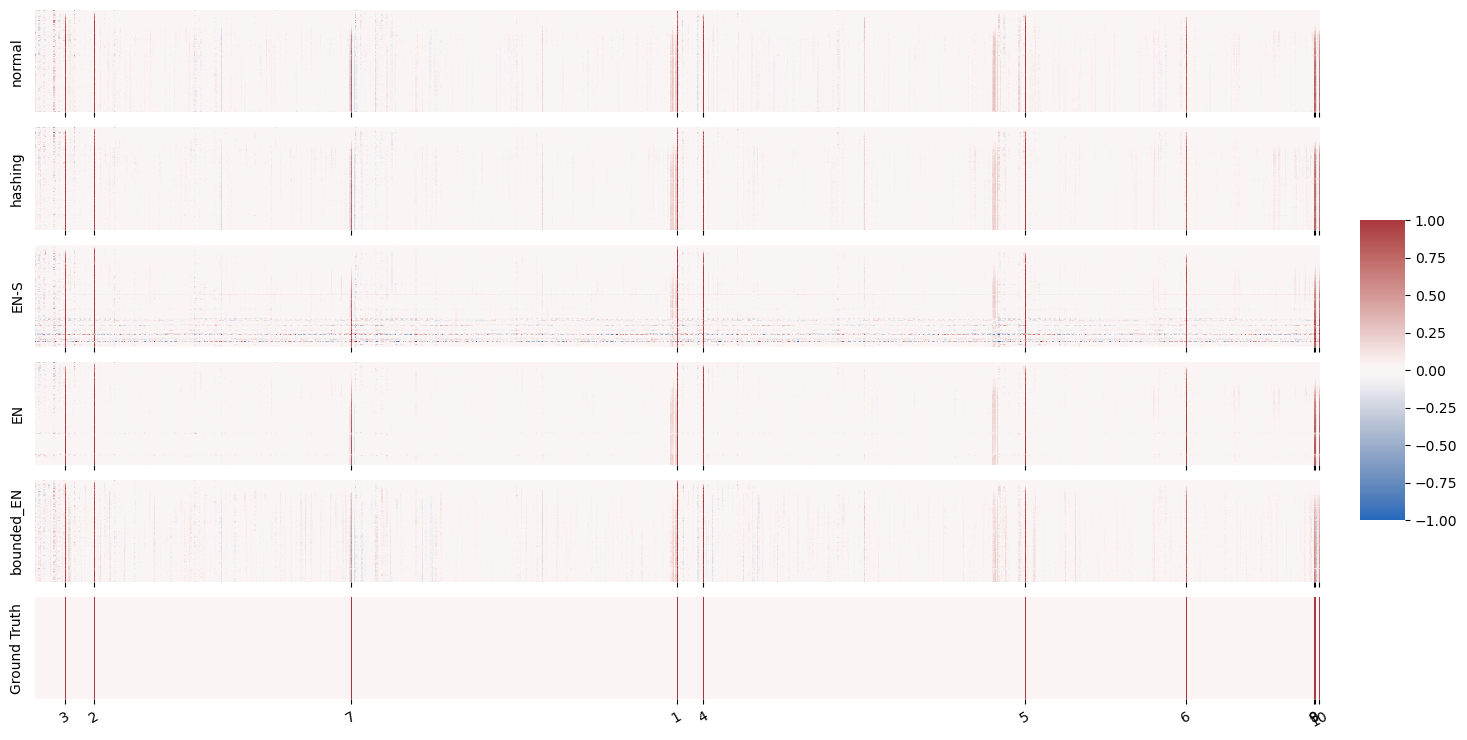

In [62]:
# Plot resltssignificant
fig, axes = plt.subplots(len(results)+1, 1, figsize=(15, len(results)*1.5), sharex=True)

data_range = 1
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, (method, result) in enumerate(results.items()):
    result["normalized_spectrums"] = (np.vstack(result["spectrums"]) / 2**(test_n/2) * test_k)
    sns.heatmap(result["normalized_spectrums"][:, 1:], 
                cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[i], 
                cbar=True if i==0 else False, cbar_ax=cbar_ax)
    axes[i].set_ylabel(method)

# GT
ground_spectrum = dataset.get_fourier_spectrum().reshape(1, -1)
sns.heatmap(ground_spectrum[:, 1:], cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[-1], cbar=False)
axes[-1].set_ylabel("Ground Truth")

# Ticks
freq_degrees = torch.sum(dataset.freq_f, axis=1).int().tolist()
for ax in axes:
    ax.set_xticks([x-1 for x in dataset.get_int_freqs()], freq_degrees, rotation=30)
    ax.set_yticks([])

fig.tight_layout(rect=[0, 0, .9, 1])

## Sorted by degree

/scratch/251685174.tmpdir/ipykernel_129130/75842020.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


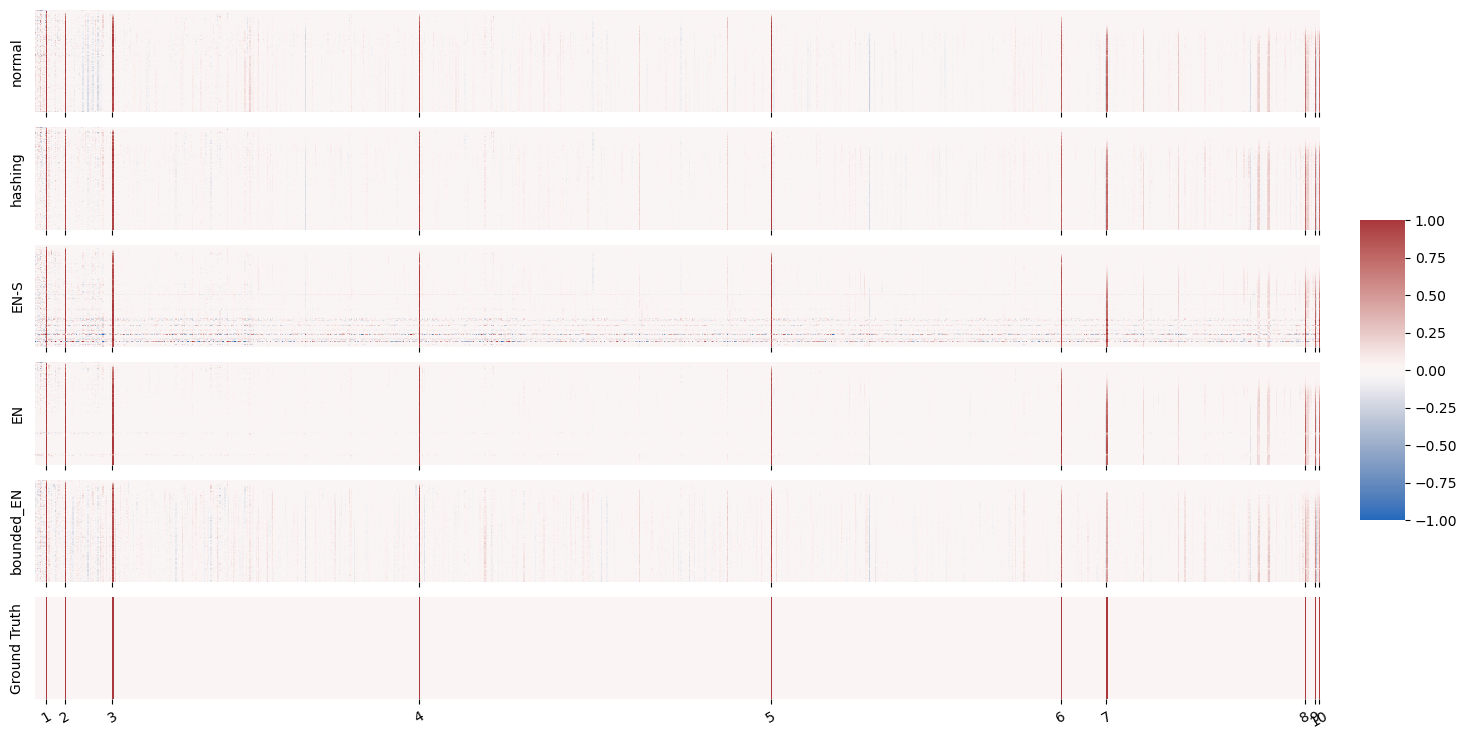

In [63]:
ind_degrees = [(np.binary_repr(i).count('1'), i) for i in range(1 , ground_spectrum.shape[1])]
deg_sorted_ind = [t[1] for t in sorted(ind_degrees)]
sorted_degs = [t[0] for t in sorted(ind_degrees)]
deg_start_inds = [sorted_degs.index(i) for i in range(1, sorted_degs[-1] + 1)]

# Plot reslts
fig, axes = plt.subplots(len(results)+1, 1, figsize=(15, len(results)*1.5), sharex=True)

data_range = 1
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, (method, result) in enumerate(results.items()):
    result["sorted_spectrums"] = result["normalized_spectrums"][:, deg_sorted_ind]
    sns.heatmap(result["sorted_spectrums"][:], 
                cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[i], 
                cbar=True if i==0 else False, cbar_ax=cbar_ax)
    axes[i].set_ylabel(method)

# GT
ground_spectrum_sorted = dataset.get_fourier_spectrum().reshape(1, -1)[:, deg_sorted_ind]
sns.heatmap(ground_spectrum_sorted, cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[-1], cbar=False)
axes[-1].set_ylabel("Ground Truth")

# Ticks
freq_degrees = torch.sum(dataset.freq_f, axis=1).int().tolist()
for ax in axes:
    ax.set_xticks([deg_sorted_ind.index(ind) for ind in dataset.get_int_freqs()], freq_degrees, rotation=30)
#     ax.vlines(deg_start_inds[1:], *ax.get_ylim(), color="black", linestyles="dashed")
    ax.set_yticks([])
fig.tight_layout(rect=[0, 0, .9, 1])



## Evolution over dataset frequencies

[ 512   48   25  533  789  917  253 1020 1019 1023]
[9, 24, 62, 306, 586, 817, 853, 1011, 1019, 1022]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


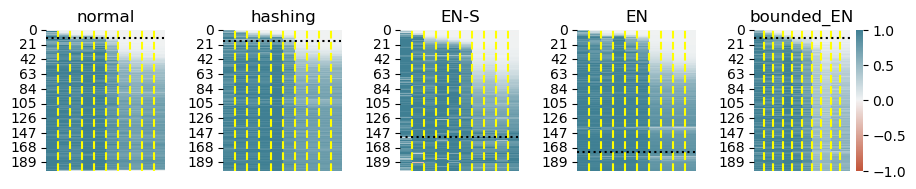

In [64]:
int_freqs = sorted([deg_sorted_ind.index(ind) for ind in dataset.get_int_freqs()])
degs = [sorted_degs[ind] for ind in int_freqs]
seps = [degs.index(i) if i in degs else 0 for i in range(2, degs[-1] + 1)]
print(dataset.get_int_freqs())
print(int_freqs)
print(degs)
print(ground_spectrum_sorted[0, int_freqs])

fig, axes = plt.subplots(1, len(results), figsize=(9, 2))
fig.tight_layout()

data_range = 1
cmap = sns.diverging_palette(20, 220, as_cmap=True)
for i, (method, result) in enumerate(results.items()):
    sns.heatmap(pd.DataFrame(result["sorted_spectrums"][:, int_freqs] / ground_spectrum_sorted[0, int_freqs], columns=degs), 
                cmap=cmap, vmin=-data_range, vmax=data_range, ax=axes[i], 
                cbar=False if i<len(results) -1 else True)
    axes[i].set_title(method)
    axes[i].vlines(seps, *axes[i].get_ylim(), color="yellow", linestyles="dashed")
    axes[i].hlines(result["best"], *axes[i].get_xlim(), color="black", linestyles="dotted")
    axes[i].set_xticks([])


# Energy errors

## Over dataset frequencies

(0.0, 1.0388613964426738)

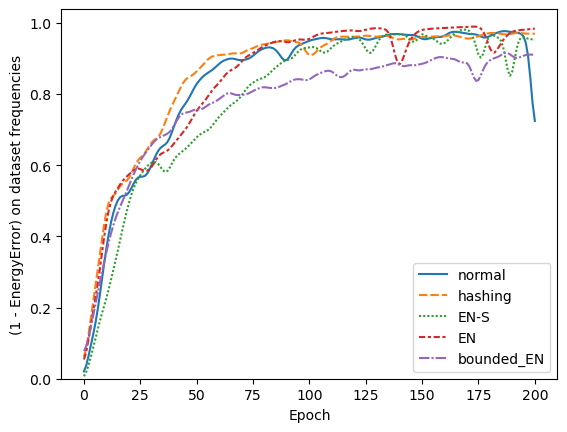

In [65]:
def covered_energy(ground_amps, learned_amps):
    return 1 - np.sum((learned_amps-ground_amps)**2) / np.sum(ground_amps**2)

int_freqs = dataset.get_int_freqs()

data = {}
for i, (method, result) in enumerate(results.items()):
    data[method] = [covered_energy(ground_spectrum[0, int_freqs], result["normalized_spectrums"][epoch, int_freqs]) 
                    for epoch in range(len(result["spectrums"]))]
    data[method] = gaussian_filter1d(data[method], sigma=2)

g = sns.lineplot(data=data)
g.set_xlabel("Epoch")
g.set_ylabel("(1 - EnergyError) on dataset frequencies")
g.set_ylim(0)

## Over whole spectrum

(0.0, 1.1309655866669055)

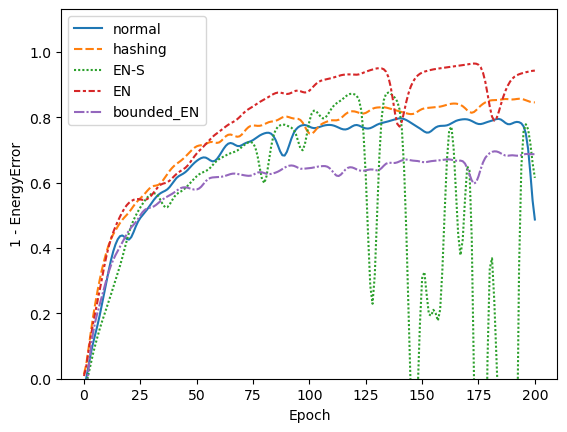

In [66]:
data = {}
for i, (method, result) in enumerate(results.items()):
    data[method] = [covered_energy(ground_spectrum[0, 1:], result["normalized_spectrums"][epoch, 1:]) 
                    for epoch in range(len(result["spectrums"]))]
    data[method] = gaussian_filter1d(data[method], sigma=2)
    
g = sns.lineplot(data=data)
g.set_xlabel("Epoch")
g.set_ylabel("1 - EnergyError")
g.set_ylim(0)

## Splitted by degree, colored by method (over whole spectrum)

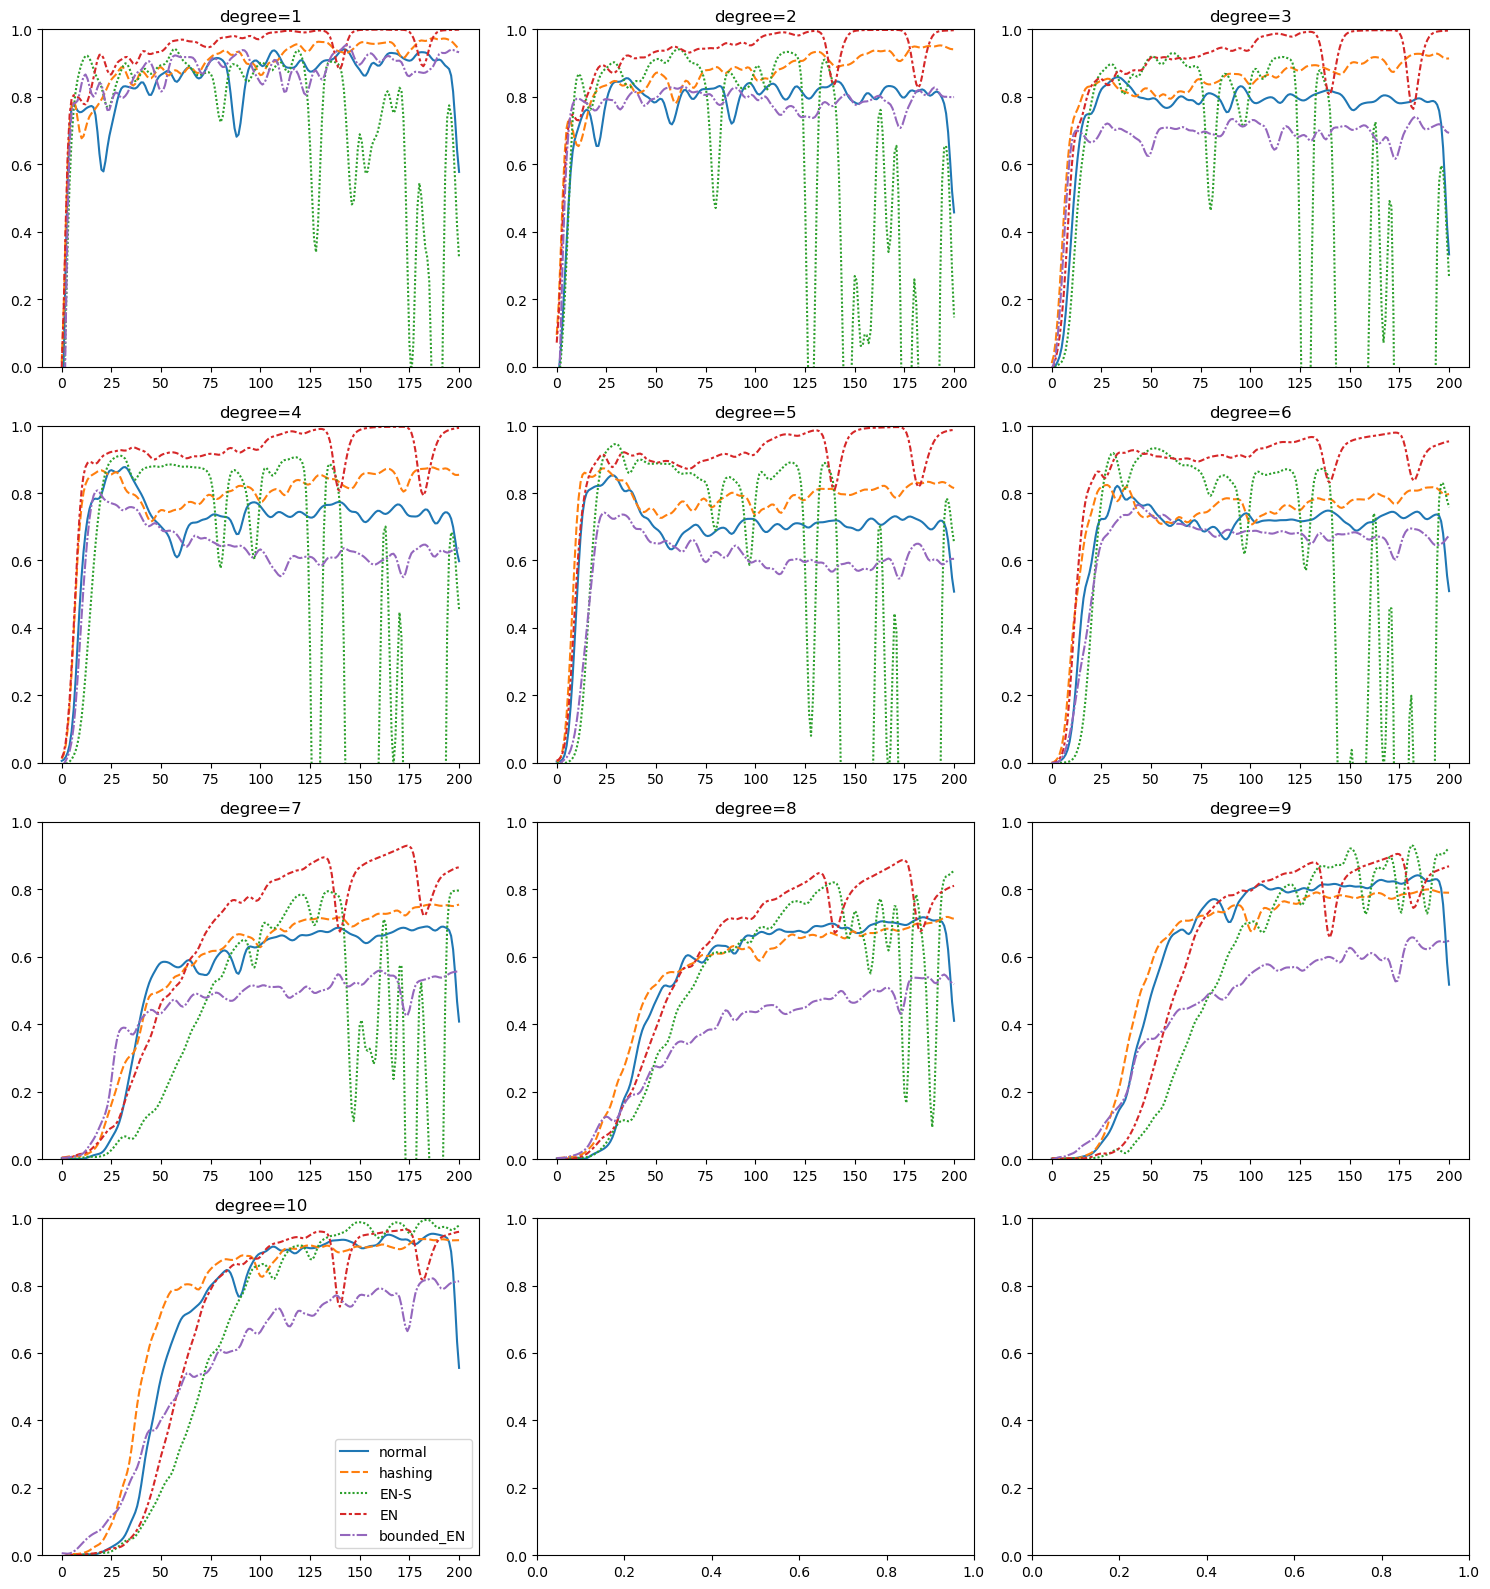

In [67]:
n_col = 3
count = test_n
fig, axes = plt.subplots(math.ceil(count/n_col), n_col, figsize=(15, math.ceil(count/n_col)*(12/n_col)))
                                                         
for i in range(count):
    indices = range(deg_start_inds[i], deg_start_inds[i+1] if i+1 < count else deg_start_inds[i] + 1)
    ax = axes[i//n_col, i%n_col]
    
    data = {}
    for j, (method, result) in enumerate(results.items()):
        data[method] = [covered_energy(ground_spectrum_sorted[0, indices], result["sorted_spectrums"][epoch, indices]) 
                        for epoch in range(len(result["spectrums"]))]
        data[method] = gaussian_filter1d(data[method], sigma=2)

    g = sns.lineplot(data=data, ax=ax, legend=False if i != count -1 else True)
    ax.set_ylim((0, 1))
    ax.set_title(f"degree={i+1}")

# handles, labels = axes[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
fig.tight_layout()

## Splitted by method, colored by degree (over whole spectrum)

/scratch/251685174.tmpdir/ipykernel_129130/1317577579.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - np.sum((learned_amps-ground_amps)**2) / np.sum(ground_amps**2)
/cluster/project/infk/krause/agorji/miniconda3/envs/whreg/lib/python3.10/site-packages/seaborn/relational.py:414: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  cis = grouped.apply(bootstrapped_cis)
/cluster/project/infk/krause/agorji/miniconda3/envs/whreg/lib/python3.10/site-packages/seaborn/relational.py:414: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the

/scratch/251685174.tmpdir/ipykernel_129130/1317577579.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - np.sum((learned_amps-ground_amps)**2) / np.sum(ground_amps**2)
/cluster/project/infk/krause/agorji/miniconda3/envs/whreg/lib/python3.10/site-packages/seaborn/relational.py:414: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  cis = grouped.apply(bootstrapped_cis)
/cluster/project/infk/krause/agorji/miniconda3/envs/whreg/lib/python3.10/site-packages/seaborn/relational.py:414: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the

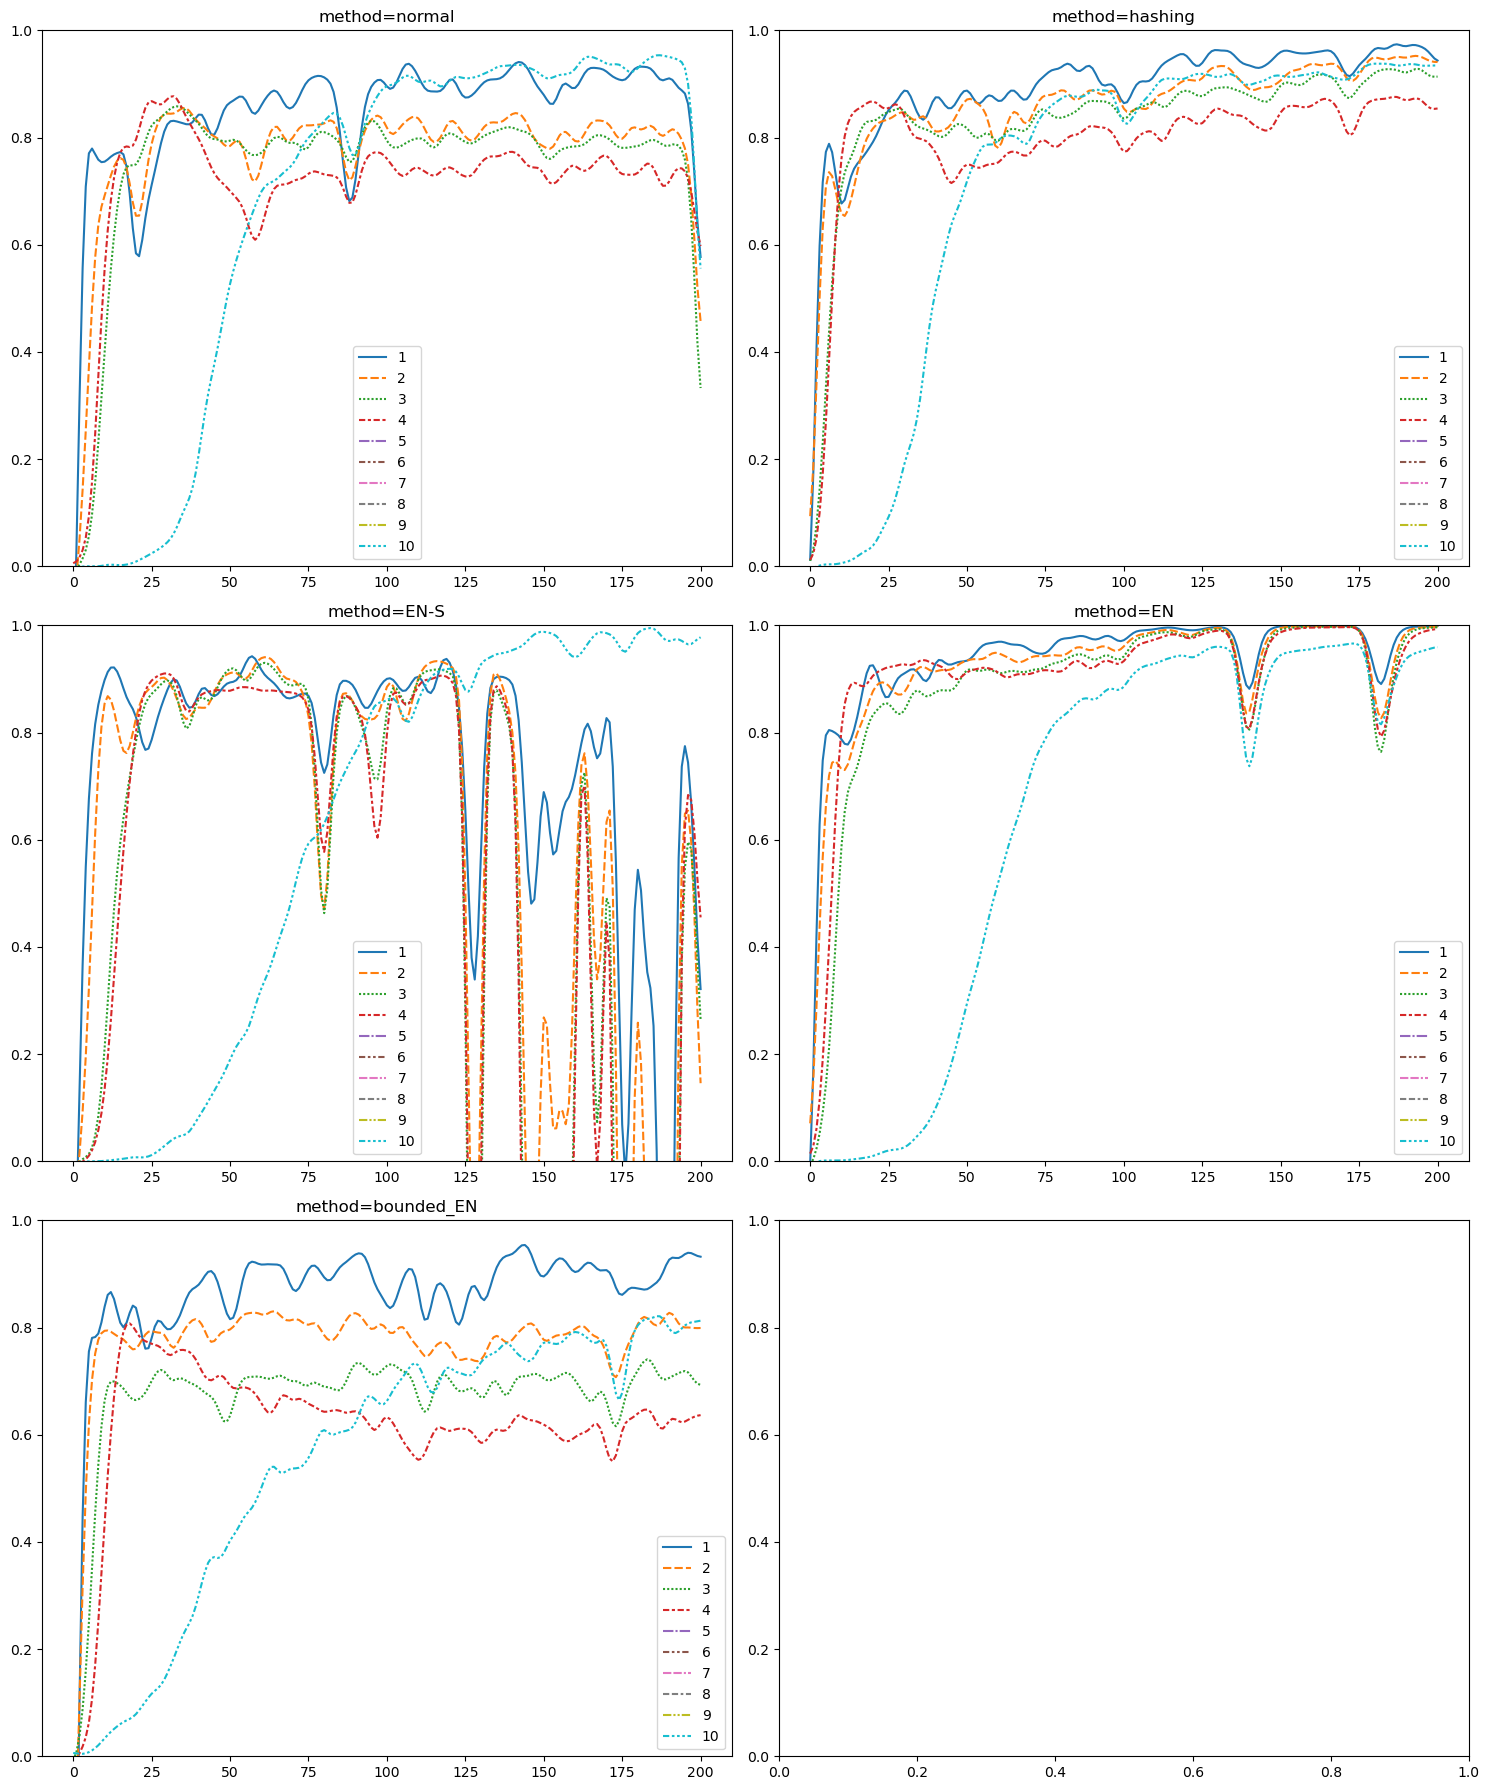

In [68]:
n_col = 2
count = len(results)
fig, axes = plt.subplots(math.ceil(count/n_col), n_col, figsize=(15, math.ceil(count/n_col)*(12/n_col)))

for j, (method, result) in enumerate(results.items()):
    ax = axes[j//n_col, j%n_col]
    
    data = {}
    for i in range(len(deg_start_inds)):
        indices = range(deg_start_inds[i], deg_start_inds[i+1] if i+1 < count else deg_start_inds[i] + 1)
        data[i+1] = [covered_energy(ground_spectrum_sorted[0, indices], result["sorted_spectrums"][epoch, indices]) 
                        for epoch in range(len(result["spectrums"]))]
        data[i+1] = gaussian_filter1d(data[i+1], sigma=2)

    g = sns.lineplot(data=data, ax=ax, legend=True)
    ax.set_ylim((0, 1))
    ax.set_title(f"method={method}")

# handles, labels = axes[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
fig.tight_layout()

# Sparsity evolution

Text(0, 0.5, 'Count of frequencies with significant amplitudes')

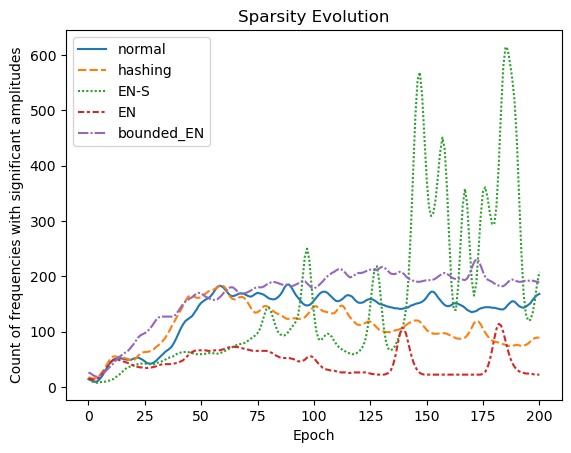

In [69]:
threshold = 5e-2

data = {}
for i, (method, result) in enumerate(results.items()):
    data[method] = np.sum(np.abs(result["normalized_spectrums"]) > threshold, axis=1)
    data[method] = gaussian_filter1d(data[method], sigma=2)    

g = sns.lineplot(data=data)
g.set_title("Sparsity Evolution")
g.set_xlabel("Epoch")
g.set_ylabel("Count of frequencies with significant amplitudes")

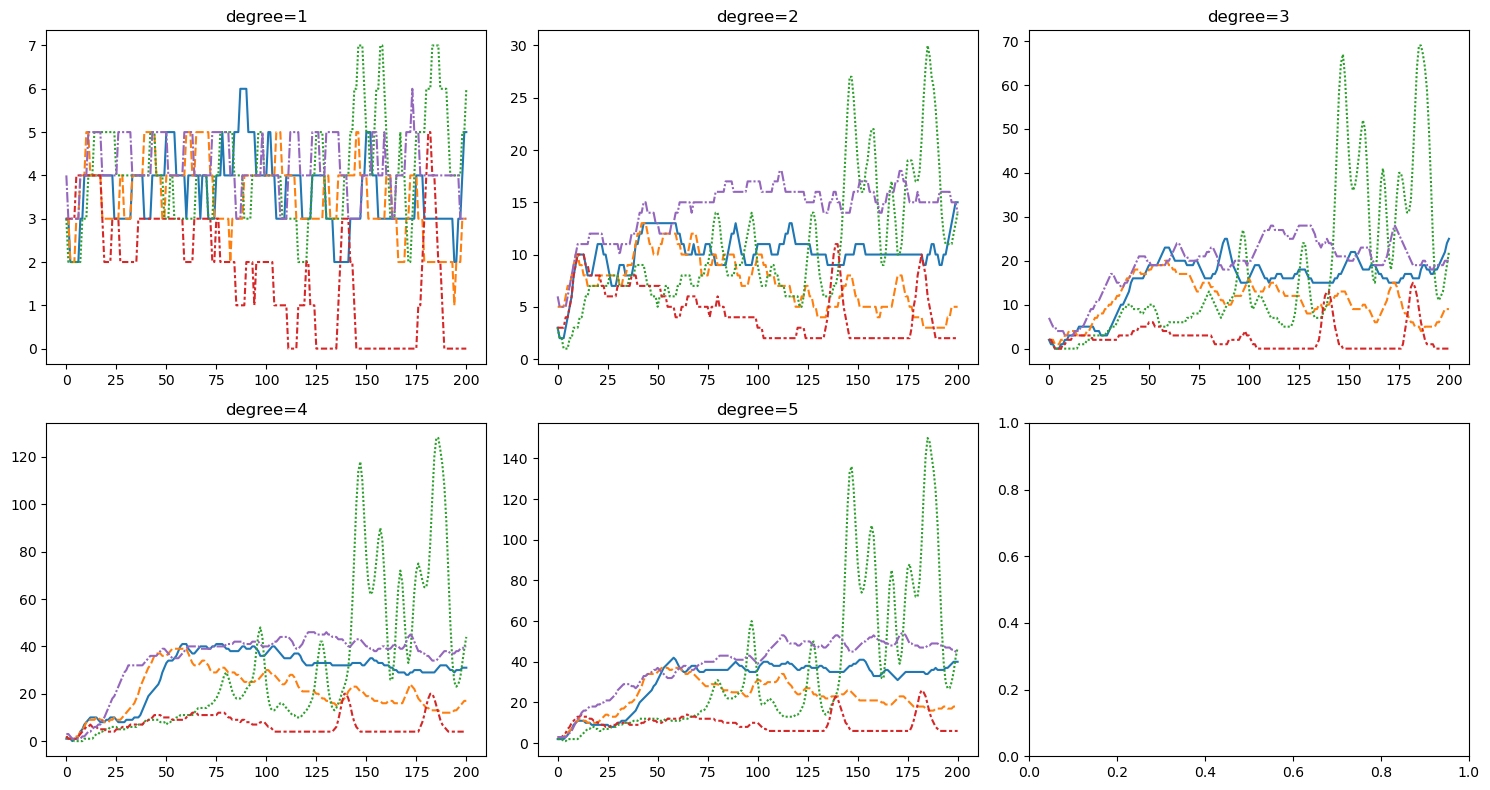

In [70]:
n_col = 3
count = test_d
fig, axes = plt.subplots(math.ceil(count/n_col), n_col, figsize=(15, math.ceil(count/n_col)*(12/n_col)))
                                                         
for i in range(count):
    indices = range(deg_start_inds[i], deg_start_inds[i+1])
    ax = axes[i//n_col, i%n_col]
    
    data = {}
    for j, (method, result) in enumerate(results.items()):
        data[method] = np.sum(np.abs(result["normalized_spectrums"][:, indices]) > threshold, axis=1)
        data[method] = gaussian_filter1d(data[method], sigma=2)

    g = sns.lineplot(data=data, ax=ax, legend=False)
    ax.set_title(f"degree={i+1}")

# handles, labels = axes[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
fig.tight_layout()